## POLYGRAPHS DATA ANALYSIS ##

In [130]:
import os 
import networkx as nx
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import warnings

Importing Polygraphs processor

In [5]:
os.chdir("/Users/fi3502phd/Desktop/Polygraphs") #changing current working directory and setting it to Polygraphs
from polygraphs.analysis import Processor #import Processor to analyze results

## Methods and Functions ##

In [6]:
class StructureProcessor(Processor): #adding desired features to the processor
    def __init__(self, path):
        super().__init__(path)
        # Add the columns when processor is initialised
        self.add(self.length(), self.edges(), self.clustering(), self.density(), self.average_shortest_path(), self.average_degree(), self.diameter())
        
    def length(self):
        """Determine the length (=size) of the graph for all sims"""
        length_list = [len(graph) for graph in self.graphs]
        self.dataframe["length"] = length_list  
        
    def edges(self):
        """Use NetworkX to count number of edges in graph for all sims"""
        edges_list = [nx.number_of_edges(graph) for graph in self.graphs]
        self.dataframe["edges"] = edges_list

    def clustering(self):
        """Use NetworkX to calculate the average clustering coefficient in graph for all sims"""
        clustering_list = [nx.average_clustering(graph) for graph in self.graphs]
        self.dataframe["avg clustering"] = clustering_list

    def density(self):
        """Use NetworkX to calculate the density of the graph for all sims"""
        density_list = [nx.density(graph) for graph in self.graphs]
        self.dataframe["density"] = density_list

    def average_shortest_path(self): 
        """Use NetworkX to calculate the average shortest path of the graph for all sims"""
        avg_shortestpath_list = [nx.average_shortest_path_length(graph) for graph in self.graphs]
        self.dataframe["average shortest path"] = avg_shortestpath_list

    def average_degree(self):
        """Use NetworkX to calculate the average neighbor degree of the graph for all sims"""
        avg_degree_list = [sum(d for n, d in graph.degree()) / graph.number_of_nodes() for graph in self.graphs]
        self.dataframe["average degree"] = avg_degree_list       
    
    def diameter(self):
        """Use NetworkX to calculate the diameter of the graph for all sims"""
        diameter_list = [nx.diameter(graph) for graph in self.graphs]
        self.dataframe["diameter"] = diameter_list      

In [12]:
def filter_cols(df, column_names): 
    
    """ Function to filter through our datafr columns and extract data on specific simualtions. 
    
    Args:
    df(pd.Dataframe.series): dataframe to be filtered
    column_names(list): names of columns to filter through

    Returns: 
    filtered dataframe
    
    """
    
    filter_values = []
    for column_name in column_names:
        value_to_filter = input(f"What value do you want to filter by for column '{column_name}'? ") 
        filter_values.append((column_name, value_to_filter))
    
    filtered_df = df.copy()
    for column_name, value_to_filter in filter_values:
        if column_name in df.columns:  # Check if input matches any column name
            try:
                # Attempt to convert value_to_filter to float
                value_to_filter = float(value_to_filter)
                filtered_df = filtered_df[filtered_df[column_name] == value_to_filter]
            except ValueError:
                # If conversion to float fails, treat as string
                filtered_df = filtered_df[filtered_df[column_name].astype(str) == value_to_filter]
        else:
            print(f"Column '{column_name}' not found!")
            return pd.DataFrame()  # Return an empty DataFrame if any column is not found

    # Drop the old index column if it exists
    if 'Unnamed: 0' in filtered_df.columns:
        filtered_df.drop(columns=['Unnamed: 0'], inplace=True)

    # Reset the index of the filtered DataFrame
    filtered_df.reset_index(drop=True, inplace=True)

    print(f"There are {len(filtered_df)} simulations for the selected parameters")
    
    return filtered_df  # Returns filtered dataframe based on input

In [13]:
def plot_parameter_distribution(df, parameter, min_points=1):
    """
    Function to plot the KDE distribution of a specified parameter grouped by the number of attachments.
    Also includes a rug plot to visualize individual data points only when necessary.

    Args:
    df (pd.DataFrame): The dataframe containing the data.
    parameter (str): The name of the parameter to plot.
    min_points (int): Minimum number of data points required to plot KDE.

    Returns:
    None
    """
    if parameter not in df.columns:
        print(f"Parameter '{parameter}' not found in the DataFrame.")
        return
    
    if 'network_barabasialbert_attachments' not in df.columns:
        print("Column 'network_barabasialbert_attachments' not found in the DataFrame.")
        return

    # Get unique values of the attachments and sort them
    unique_attachments = sorted(df['network_barabasialbert_attachments'].unique())

    # Create a figure with a grid of subplots
    num_cols = 3
    num_rows = (len(unique_attachments) + num_cols - 1) // num_cols  # Ceiling division
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 4))
    axes = axes.flatten()  # Flatten to easily iterate over axes

    # Add super title
    fig.suptitle(f"{parameter} distribution based on attachments", fontsize=16, color='brown', fontweight='bold')

    # Plot the KDE or rug plot for each unique attachment value
    for i, attachment in enumerate(unique_attachments):
        subset = df[df['network_barabasialbert_attachments'] == attachment]
        ax = axes[i]
        
        unique_values = subset[parameter].unique()
        
        if len(unique_values) == 1:
            # If there's only one unique value, plot rug plot
            sns.rugplot(data=subset[parameter], ax=ax, height=0.1, color='r')
            ax.set_title(f'Attachments: {attachment}, count: {len(subset)}')
            ax.set_xlabel(parameter)
            ax.set_ylabel('Density')
        elif len(subset) > min_points:
            # Plot KDE plot if there are enough data points
            sns.kdeplot(data=subset[parameter], ax=ax, fill=True)
            ax.set_title(f'Attachments: {attachment}, count: {len(subset)}')
            ax.set_xlabel(parameter)
            ax.set_ylabel('Density')
        else:
            print(f"Skipping plot for Attachments: {attachment} due to insufficient data points.")
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f'Attachments: {attachment}')
            ax.set_xlabel(parameter)
            ax.set_ylabel('Density')

    # Remove any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [14]:
def percentage_of_convergence_by_group(df, group_columns, convergence_column = "converged", action_column = "action"):
    
    """ Function to extract overall percentage of convergence, as well as percentage of convergence to wrong and right action 
    based on parameters (e.g. average clustering).

    Args:
    df(pd.Dataframe.series): dataframe 
    group_columns(list): names of columns for which to extract percentage of convergence 

    Returns:
    dataframe with percentage of convergence by group 
    """
    
    global results_df
    
    # Check if specified column(s) exist in the DataFrame
    for col in group_columns:
        if col not in df.columns:
            print(f"Column '{col}' not found in the DataFrame.")
            return None

    results = []

    # Iterate over groups
    for name, group in df.groupby(group_columns):
        # Drop rows with missing values in convergence_column or action_column
        group = group.dropna(subset=[convergence_column, action_column])
        total_rows = len(group)
        # If no rows left after dropping NA, create a default result for the group
        if total_rows == 0:
            group_result = {
                'count': 0,  # Add count column with default value 0
                'convergence_percentage': None, 
                'not_convergence_percentage': None,
                'converged_right': None,
                'converged_wrong': None,
                **dict(zip(group_columns, name if isinstance(name, tuple) else (name,)))
            }
        else:
             # Calculate convergence metrics
            converged_rows = group[convergence_column].sum()
            convergence_percentage = (converged_rows / total_rows) * 100
            not_convergence_percentage = 100 - convergence_percentage

             # Filter rows that have converged
            converged_group = group[group[convergence_column]]

            total_converged = len(converged_group)
            if total_converged > 0:
                # Calculate right and wrong convergence percentages
                right_convergence_count = len(converged_group[converged_group[action_column] == 'B'])
                right_convergence_percentage = (right_convergence_count / total_converged) * 100
                wrong_convergence_percentage = 100 - right_convergence_percentage
            else:
                right_convergence_percentage = 0
                wrong_convergence_percentage = 0

            group_result = {
                'count': total_rows,  # Add count column
                'convergence_percentage': convergence_percentage,
                'not_convergence_percentage': not_convergence_percentage,
                'converged_right': right_convergence_percentage,
                'converged_wrong': wrong_convergence_percentage,
                **dict(zip(group_columns, name if isinstance(name, tuple) else (name,)))
            }

        results.append(group_result)

    # Convert list of dictionaries to DataFrame
    results_df = pd.DataFrame(results)
    
    #results_df = results_df.dropna()
    results_df = results_df.dropna()

    return results_df

def plot_convergence(result, group_column, hue_column, round_column = None):
    unique_group_values = sorted(results_df[group_column].unique())
    #Check that column reliability exists 
    if "reliability" in result.columns:
        # Sort by reliability
        result = result.sort_values(by='reliability', ascending = False)
        unique_reliabilities = result['reliability'].unique()
    for reliability in unique_reliabilities:
        subset = result[result['reliability'] == reliability]

        if subset.empty:
            print(f"No data for reliability {reliability}. Skipping plot for this reliability.")
            continue

        plt.figure(figsize=(10, 6))
        plt.grid(alpha = 0.5)
        sns.lineplot(data = subset, x = group_column, y = "converged_right", hue = hue_column, marker ='o', palette = "bright")
        plt.title(f'Effect of {group_column} on convergence', fontsize=14)
        plt.xlabel(f'{group_column}', fontsize=12)
        plt.ylabel('Rate of convergence', fontsize=12)
        plt.xticks(unique_group_values)
        plt.legend(title='Op')
        plt.suptitle(f'Reliability {reliability}', fontsize=16, fontweight = 'bold', color = 'black', x=0.5)

In [48]:
def plot_convergence(result, group_column, hue_column, round_column=None):
    unique_group_values = sorted(result[group_column].unique())
    
    # Check that column reliability exists 
    if "reliability" in result.columns:
        # Sort by reliability
        result = result.sort_values(by='reliability', ascending=False)
        unique_reliabilities = result['reliability'].unique()
        
    # Determine the y-axis limits across all reliability levels
    global_y_min = -5
    global_y_max = 105

    for reliability in unique_reliabilities:
        subset = result[result['reliability'] == reliability]

        if subset.empty:
            print(f"No data for reliability {reliability}. Skipping plot for this reliability.")
            continue

        plt.figure(figsize=(10, 6))
        plt.grid(alpha=0.5)
        
        # Create a custom palette
        palette = sns.color_palette("bright", len(subset[hue_column].unique()))
        custom_palette = {op: 'green' if op == 'BalaGoyalOp' else palette[i] 
                          for i, op in enumerate(subset[hue_column].unique())}
        
        sns.lineplot(data=subset, x=group_column, y="converged_right", hue=hue_column, marker='o', palette=custom_palette)
        
        plt.title(f'Effect of {group_column} on convergence', fontsize=14)
        plt.xlabel(f'{group_column}', fontsize=12)
        plt.ylabel('Rate of convergence', fontsize=12)
        plt.xticks(unique_group_values)
        plt.ylim(global_y_min, global_y_max)  # Set the same y-axis limits for all plots
        plt.legend(title='Op')
        plt.suptitle(f'Reliability {reliability}', fontsize=16, fontweight='bold', color='black', x=0.5)
        
        plt.show()

In [50]:
def stats(df, group_columns, x_axis):
    """
    Calculate and plot step statistics for converged data where action is 'B'.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    group_columns (list): The columns to group by for calculating statistics.
    x_axis (str): The column name to be used as the x-axis in the plot.

    Returns:
    DataFrame with step statistics.
    """
    global step_stats_tab
    unique_group_values = sorted(df[x_axis].unique())
    # Rounding off the x_axis column if it is of type float
    if df[x_axis].dtype == float:
        df[x_axis] = df[x_axis].apply(lambda x: round(x, 2))
    
    # Filtering the dataframe to include only rows where 'converged' is True and 'action' is 'B'
    converged_to_B = df.query("converged == True & action == 'B'")
    if converged_to_B.empty:
        print("The filtered dataframe is empty.")
        return None
    
    # Grouping by the specified column(s) and describing the 'steps' column
    step_stats_tab = converged_to_B.groupby(group_columns).steps.describe().sort_values("mean")
    if step_stats_tab.empty:
        print("The grouped dataframe is empty.")
        return None
    
    # Setting the Seaborn grid style
    sns.set(style="whitegrid")

    # Define specific colors for the ops
    colors = {
        'BalaGoyalOp': 'green',
        'UnreliableNetworkBasicGullibleBinomialOp': 'blue',
        'UnreliableNetworkBasicGullibleNegativeEpsOp': 'orange'
    }

    # Sort reliability values from highest to lowest
    unique_reliabilities = sorted(converged_to_B['reliability'].unique(), reverse=True)
    
    # Iterate over each reliability level to create a plot
    for i in range(len(unique_reliabilities) - 1):
        reliability_high = unique_reliabilities[0]  # Always start with reliability 1
        reliability_low = unique_reliabilities[i + 1]
        
        plt.figure(figsize=(10, 6))
        
        # Filter data subset for the current reliability levels
        data_high = converged_to_B[converged_to_B['reliability'] == reliability_high]
        data_low = converged_to_B[converged_to_B['reliability'] == reliability_low]
        
        # Calculate mean and standard deviation for each group
        means_high = data_high.groupby([x_axis, 'op'])['steps'].mean().reset_index()
        stds_high = data_high.groupby([x_axis, 'op'])['steps'].std().reset_index()
        
        means_low = data_low.groupby([x_axis, 'op'])['steps'].mean().reset_index()
        stds_low = data_low.groupby([x_axis, 'op'])['steps'].std().reset_index()
        
        # Plot line with error bars for reliability_high
        for op in means_high['op'].unique():
            mean_op = means_high[means_high['op'] == op]
            std_op = stds_high[stds_high['op'] == op]
            plt.errorbar(
                mean_op[x_axis], 
                mean_op['steps'], 
                yerr=std_op['steps'], 
                label=f"{op} (Reliability {reliability_high})", 
                marker='o', 
                markersize=5,  
                color=colors.get(op, 'black')  
            )
        
        # Plot line with error bars for reliability_low
        for op in means_low['op'].unique():
            mean_op = means_low[means_low['op'] == op]
            std_op = stds_low[stds_low['op'] == op]
            plt.errorbar(
                mean_op[x_axis], 
                mean_op['steps'], 
                yerr=std_op['steps'], 
                label=f"{op} (Reliability {reliability_low})", 
                marker='x', 
                markersize=5,  
                linestyle='--',  # Set dashed line style
                color=colors.get(op, 'black')  
            )
        
        plt.title(f'Speed of Convergence (Reliability {reliability_high} vs {reliability_low})', weight='bold')
        plt.xlabel(x_axis)
        plt.ylabel('Number of Steps')
        plt.xticks(unique_group_values)
        plt.legend(title='Operations')
        plt.show()

## Analysis ##

GETTING DATA

In [11]:
x = StructureProcessor("~/polygraphs-cache")
x.get() 

,bin_file_path,hd5_file_path,config_json_path,trials,network_size,network_kind,op,epsilon,steps,duration,...,polarized,uid,network.barabasialbert.attachments,length,edges,avg clustering,density,average shortest path,average degree,diameter
0,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,64,64.0,barabasialbert,UnreliableNetworkBasicGullibleNegativeEpsOp,0.000,100000.0,592.299177,...,False,eb40810d984b4fed8fec3742b60f1ebc,NaN,64,63,0.000000,0.03125,3.822421,1.968750,9
1,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,64,64.0,barabasialbert,UnreliableNetworkBasicGullibleNegativeEpsOp,0.000,100000.0,586.882218,...,False,eb40810d984b4fed8fec3742b60f1ebc,NaN,64,63,0.000000,0.03125,3.936012,1.968750,7
2,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,64,64.0,barabasialbert,UnreliableNetworkBasicGullibleNegativeEpsOp,0.000,100000.0,602.977834,...,False,eb40810d984b4fed8fec3742b60f1ebc,NaN,64,63,0.000000,0.03125,4.614087,1.968750,9
3,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,64,64.0,barabasialbert,UnreliableNetworkBasicGullibleNegativeEpsOp,0.000,100000.0,600.115321,...,False,eb40810d984b4fed8fec3742b60f1ebc,NaN,64,63,0.000000,0.03125,4.435020,1.968750,11
4,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,64,64.0,barabasialbert,UnreliableNetworkBasicGullibleNegativeEpsOp,0.000,100000.0,555.003337,...,False,eb40810d984b4fed8fec3742b60f1ebc,NaN,64,63,0.000000,0.03125,4.541667,1.968750,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,64,NaN,snap,UnreliableNetworkBasicGullibleNegativeEpsOp,0.001,100000.0,9735.372529,...,False,2cbc4f47027845768b3dfd52d653ac20,NaN,4039,88234,0.605547,0.01082,3.692507,43.691013,8
3898,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,64,NaN,snap,UnreliableNetworkBasicGullibleNegativeEpsOp,0.001,100000.0,9794.195010,...,False,85990f69d4b74e6dabaa0cce0e9e7a07,NaN,4039,88234,0.605547,0.01082,3.692507,43.691013,8
3899,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,64,NaN,snap,UnreliableNetworkBasicGullibleNegativeEpsOp,0.001,100000.0,9524.132547,...,False,85990f69d4b74e6dabaa0cce0e9e7a07,NaN,4039,88234,0.605547,0.01082,3.692507,43.691013,8
3900,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,/Users/fi3502phd/polygraphs-cache/results/2024...,64,NaN,snap,UnreliableNetworkBasicGullibleNegativeEpsOp,0.001,100000.0,10266.661767,...,False,f41a0cbc1f404c118df5676e53c09c42,NaN,4039,88234,0.605547,0.01082,3.692507,43.691013,8


In [12]:
x.add_config("network.barabasialbert.attachments") #adding column with barabasialbert attachments as current one is not working
x.add_config("reliability") #adding column for reliability

In [13]:
frame = x.dataframe #turn processor object into dataframe

In [14]:
frame = frame.drop("network.barabasialbert.attachments", axis = 1) #drop previous attachment column as it was not working 

In [18]:
path = "/Users/fi3502phd/Desktop/Data_analysis" #where to locate csv file

In [16]:
frame.to_csv(f"{path}/sims.csv") #save dataframe as csv

In [19]:
my_data = pd.read_csv(f"{path}/sims.csv") #import csv file for analysis 

PRELIMINAR FILTERING

In [20]:
df = filter_cols(my_data, ["network_kind"]

What value do you want to filter by for column 'network_kind'?  barabasialbert


There are 3882 simulations for the selected parameters


EXTRACT BASIC COUNTS

In [27]:
counts = df.groupby(["op", "reliability","network_barabasialbert_attachments"]).count().reset_index() #how many simulations for each op, 
                                                                                #reliability and attachments?

In [29]:
counts.to_csv(f"{path}/frame.csv") #save counts csv 

PLOT PARAMETER DISTRIBUTION BASED ON ATTACHMENTS

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

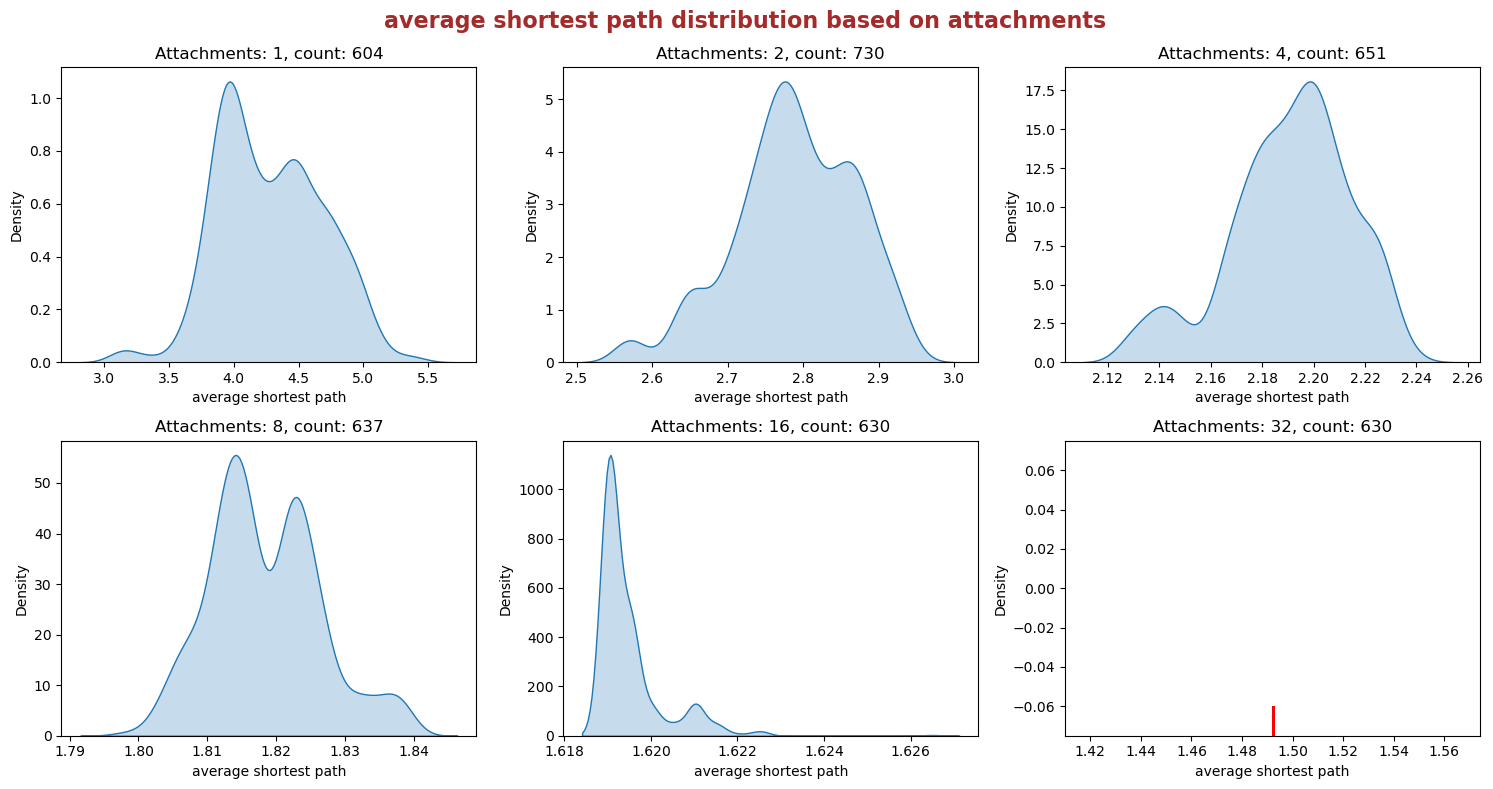

In [30]:
plot_parameter_distribution(df, "average shortest path") #plotting for average shortest path 

/var/folders/qf/q6vl1wz11b59rfbgvvvygs0c0000gq/T/ipykernel_91229/2423003364.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = my_data, x = 'network_barabasialbert_attachments', y = "average degree", marker ='o', palette = ['b'])
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


([<matplotlib.axis.XTick at 0x1ebde4390>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(8, 0, '8'),
  Text(16, 0, '16'),
  Text(32, 0, '32')])

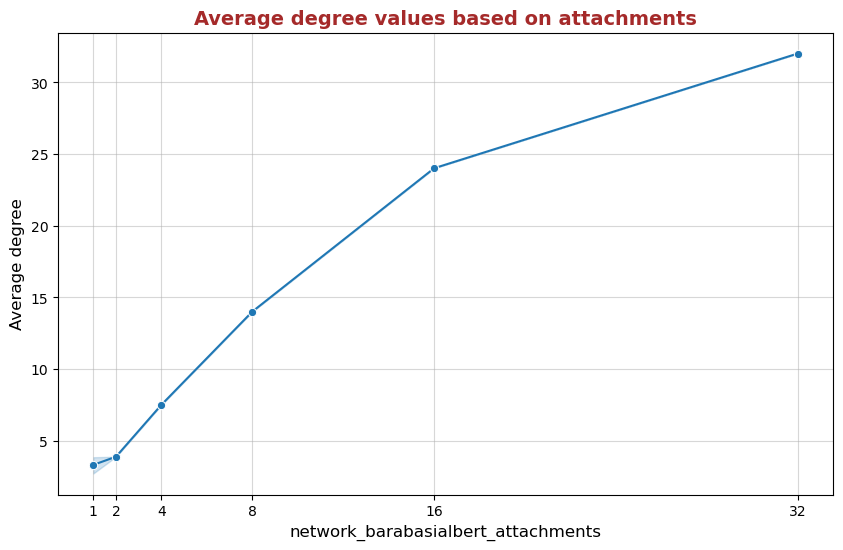

In [52]:
#plotting average degree on a line graph since there is no variance in the data for each attachment value
unique_group_values = sorted(my_data['network_barabasialbert_attachments'].unique())
plt.figure(figsize=(10, 6))
plt.grid(alpha = 0.5)
sns.lineplot(data = my_data, x = 'network_barabasialbert_attachments', y = "average degree", marker ='o', palette = ['b'])
plt.title('Average degree values based on attachments', fontsize=14, weight = 'bold', color = 'brown')
plt.xlabel('network_barabasialbert_attachments', fontsize=12)
plt.ylabel('Average degree', fontsize=12)
plt.xticks(unique_group_values)

DATA ON RELIABILITY OF CONVERGENCE

In [37]:
#extract percentage of convergence based on some parameters, in this case attachments, reliability and op
results_df = percentage_of_convergence_by_group(df, ['network_barabasialbert_attachments', 'reliability', 'op'],'converged', 'action') 

In [38]:
results_df

,count,convergence_percentage,not_convergence_percentage,converged_right,converged_wrong,network_barabasialbert_attachments,reliability,op
0,90,0.000000,100.000000,0.000000,0.000000,1,0.25,UnreliableNetworkBasicGullibleBinomialOp
1,50,10.000000,90.000000,0.000000,100.000000,1,0.25,UnreliableNetworkBasicGullibleNegativeEpsOp
2,40,0.000000,100.000000,0.000000,0.000000,1,0.50,UnreliableNetworkBasicGullibleBinomialOp
3,90,0.000000,100.000000,0.000000,0.000000,1,0.50,UnreliableNetworkBasicGullibleNegativeEpsOp
4,90,5.555556,94.444444,100.000000,0.000000,1,0.75,UnreliableNetworkBasicGullibleBinomialOp
5,74,0.000000,100.000000,0.000000,0.000000,1,0.75,UnreliableNetworkBasicGullibleNegativeEpsOp
6,90,100.000000,0.000000,100.000000,0.000000,1,1.00,BalaGoyalOp
7,90,0.000000,100.000000,0.000000,0.000000,2,0.25,UnreliableNetworkBasicGullibleBinomialOp
8,52,13.461538,86.538462,0.000000,100.000000,2,0.25,UnreliableNetworkBasicGullibleNegativeEpsOp
9,90,15.555556,84.444444,100.000000,0.000000,2,0.50,UnreliableNetworkBasicGullibleBinomialOp


In [176]:
results_df.to_csv(f"{path}/tab.csv") #save table with convergence results

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


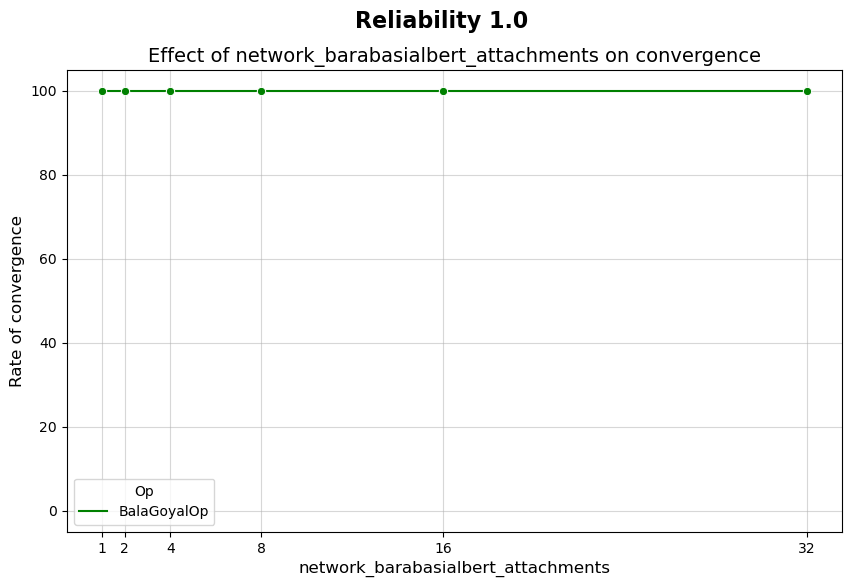

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


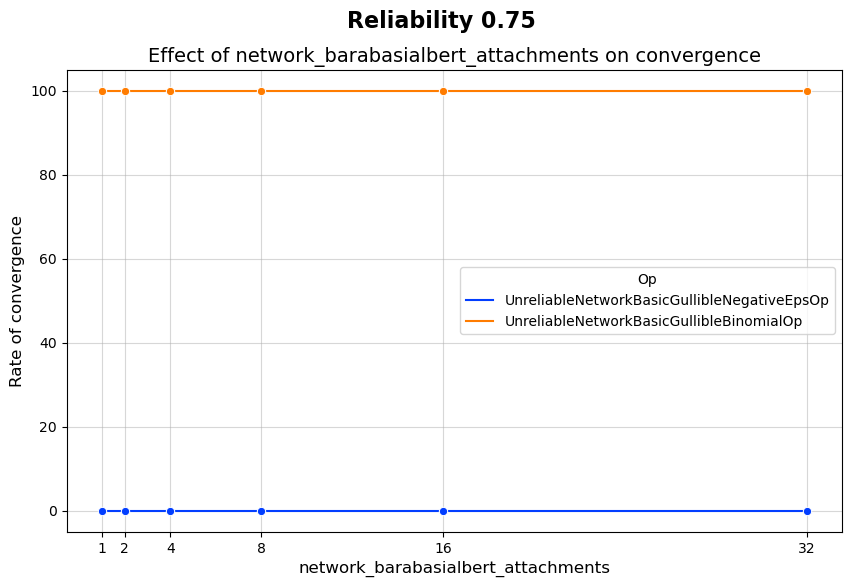

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


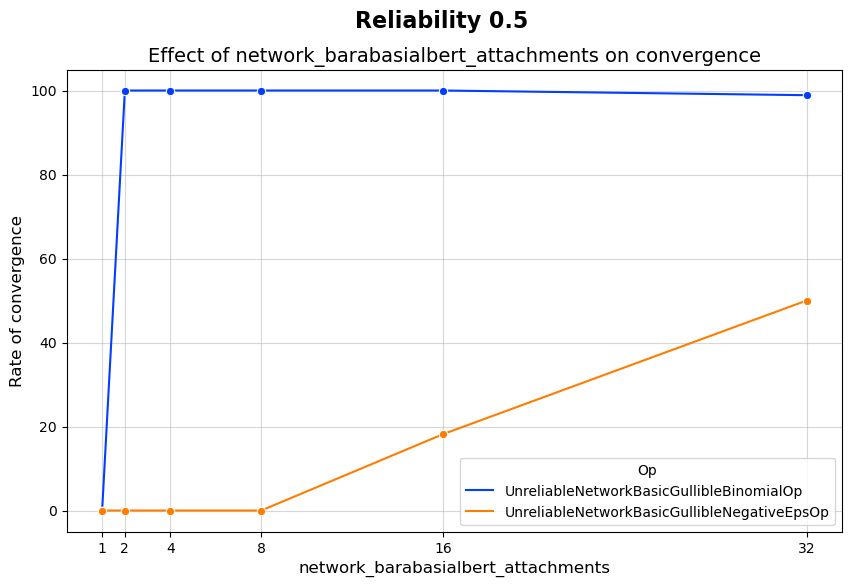

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


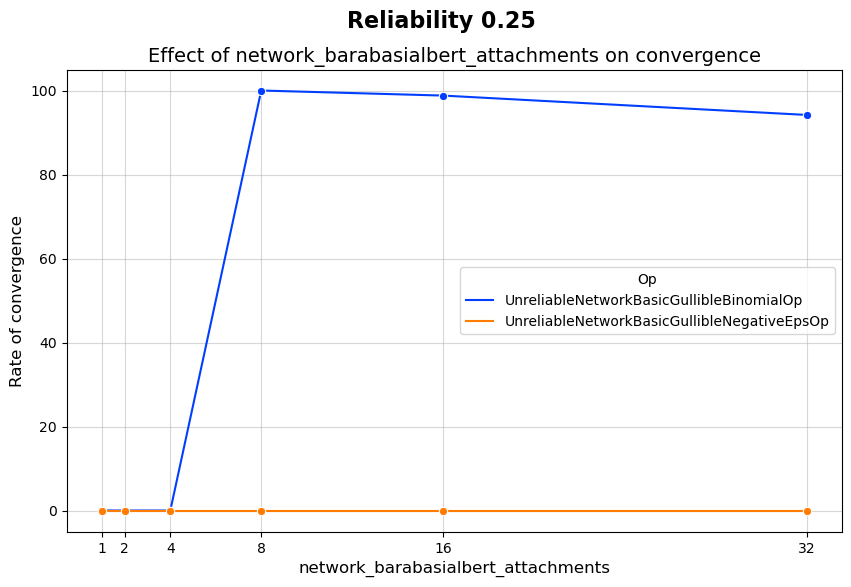

In [49]:
plot_convergence(results_df, "network_barabasialbert_attachments", "op") #display convergence results with % of convergence to B
                                                                        #(out of converged simulations) on y axis 

PLOT STATISTICS FOR STEPS

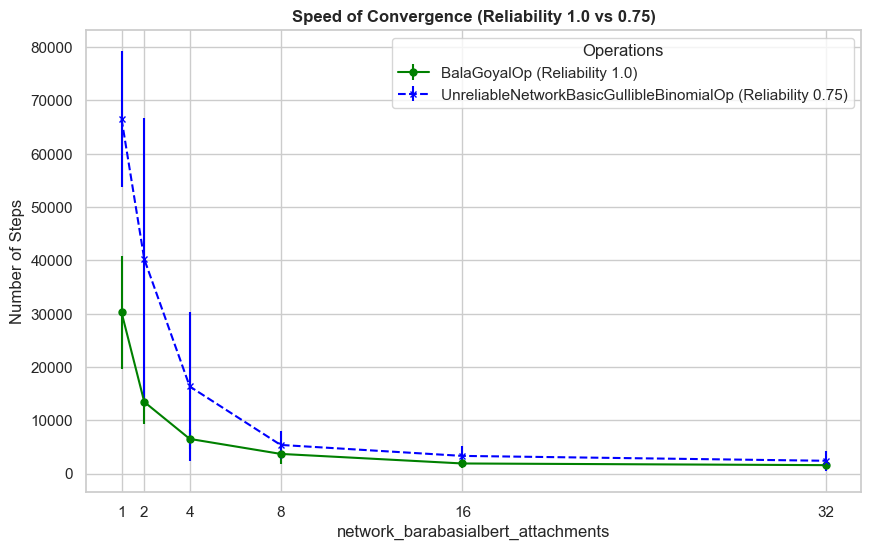

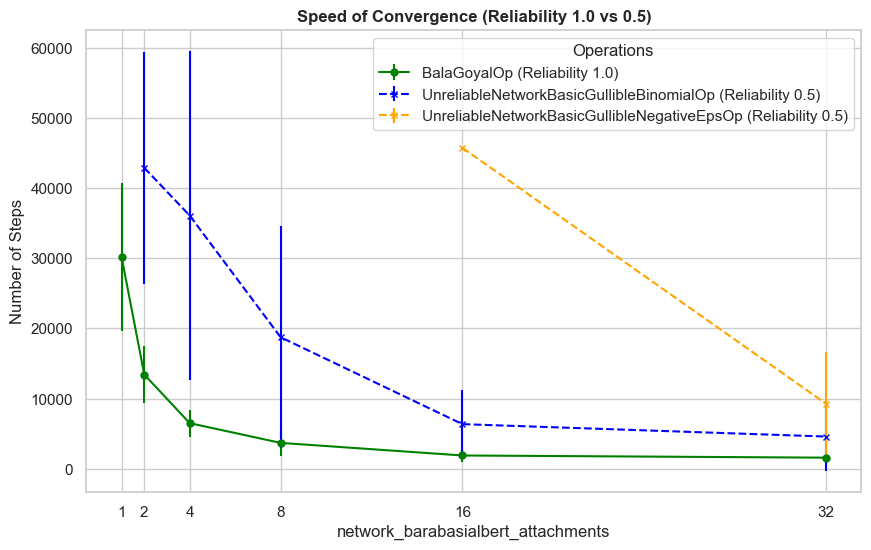

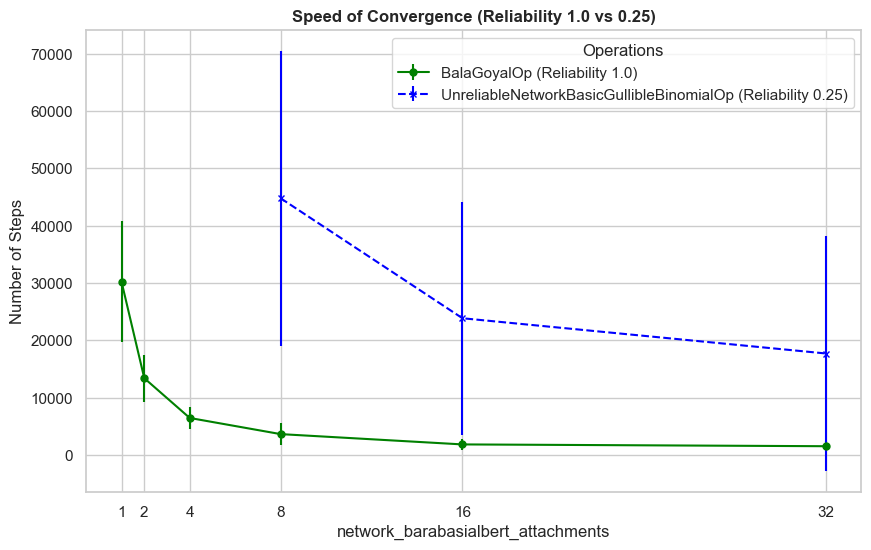

In [51]:
stats(df,["network_barabasialbert_attachments", "op"], "network_barabasialbert_attachments")

In [69]:
sorted = step_stats_tab.sort_values(['network_barabasialbert_attachments']) #sort by attachments so we can compare different operations

In [70]:
sorted

,network_barabasialbert_attachments,op,count,mean,std,min,25%,50%,75%,max
10,1,BalaGoyalOp,90.0,30218.244444,10548.909785,14908.0,22034.75,27144.5,36478.25,54085.0
13,1,UnreliableNetworkBasicGullibleBinomialOp,5.0,66516.600000,12761.624889,55047.0,58350.00,58350.0,80418.00,80418.0
7,2,BalaGoyalOp,93.0,13423.290323,4115.334203,7963.0,10486.00,12735.0,15148.00,27568.0
11,2,UnreliableNetworkBasicGullibleBinomialOp,72.0,40734.194444,24802.006039,13095.0,21912.75,32444.0,55392.00,98561.0
3,4,BalaGoyalOp,90.0,6491.944444,1909.279559,3701.0,5388.00,6086.0,7055.00,13362.0
9,4,UnreliableNetworkBasicGullibleBinomialOp,131.0,22973.564885,19973.709238,4878.0,11297.00,15560.0,24572.00,93302.0
2,8,BalaGoyalOp,90.0,3677.400000,1932.912612,1791.0,2593.25,3190.0,4288.25,16312.0
8,8,UnreliableNetworkBasicGullibleBinomialOp,233.0,19500.304721,21693.327214,2635.0,5406.00,9998.0,22195.00,95236.0
1,16,BalaGoyalOp,90.0,1881.355556,895.205084,773.0,1311.50,1683.5,2324.00,5534.0
6,16,UnreliableNetworkBasicGullibleBinomialOp,262.0,10787.629771,14724.600919,827.0,2905.25,4760.0,10849.00,99455.0


In [71]:
sorted.to_csv(f"{path}/step_stats.csv") #save csv fale

## Chi-squared Test

The chi-squared test is used to determine whether there is a statistically significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table. I am using this test to compare the proportions of A and B results from the tests against different network configurations.



In [110]:

# Group by the necessary columns and count occurrences of 'action'
grouped = df.groupby(["op", "network_barabasialbert_attachments", "reliability", "action"]).size().unstack(fill_value=0).reset_index()
grouped

# Ensure 'A' and 'B' columns are present
if 'A' not in grouped.columns:
    grouped['A'] = 0
if 'B' not in grouped.columns:
    grouped['B'] = 0

# Reorder columns to match the desired output
proportions = grouped[["network_barabasialbert_attachments", "op", "reliability", "A", "B"]]

# Drop the '?' column if it exists
if '?' in proportions.columns:
    proportions = proportions.drop("?", axis=1)

In [107]:
proportions.to_csv("proportions.csv")

In [108]:
# Dataframe to store Chi2 results
chi2_results = pd.DataFrame()

# List of operations to compare
operations = proportions['op'].unique()

# Iterate over operations
for idx, op in enumerate(operations):
    # Filter data for the current operation
    op_data = proportions.query("op == @op").copy()

    # Group by Attachments and Reliability
    for attachments, attachments_group in op_data.groupby('network_barabasialbert_attachments'):
        for reliability, reliability_group in attachments_group.groupby('reliability'):
            # Get A and B values for the current Attachments and Reliability
            A_values = reliability_group['A'].values
            B_values = reliability_group['B'].values

            # Iterate over other operations to compare
            for compared_op in operations[idx + 1:]:
                # Filter data for the compared operation
                compared_data = proportions.query("op == @compared_op").copy()

                # Match Attachments and Reliability
                compared_group = compared_data[(compared_data['network_barabasialbert_attachments'] == attachments) & 
                                               (compared_data['reliability'] == reliability)]

                if not compared_group.empty:
                    # Get A and B values for the compared operation
                    compared_A = compared_group['A'].values[0]
                    compared_B = compared_group['B'].values[0]

                    try:
                        # Calculate Chi2
                        chi2, p, dof, expected = chi2_contingency([[A_values.sum(), B_values.sum()], [compared_A, compared_B]])
                    except ValueError:
                        chi2, p, dof, expected = 0, 1, 0, [[0, 0], [0, 0]]

                    # Prepare result row
                    result_row = pd.DataFrame({
                        'Op': [op],
                        'Attachments': [attachments],
                        'Reliability': [reliability],
                        'A': [A_values.sum()],
                        'B': [B_values.sum()],
                        'Compared_Op': [compared_op],
                        'Compared_A': [compared_A],
                        'Compared_B': [compared_B],
                        'Chi2': [chi2],
                        'P_value': [p],
                        'Degrees_of_Freedom': [dof]
                    })

                    # Append to results DataFrame
                    chi2_results = pd.concat([chi2_results, result_row], ignore_index=True)

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/contingency.py:134: RuntimeWarning: invalid value encountered in divide
  expected = reduce(np.multiply, margsums) / observed.sum() ** (d - 1)


In [111]:
chi2_results.query("P_value < 0.05") 

,Op,Attachments,Reliability,A,B,Compared_Op,Compared_A,Compared_B,Chi2,P_value,Degrees_of_Freedom
7,UnreliableNetworkBasicGullibleBinomialOp,4,0.50,0,44,UnreliableNetworkBasicGullibleNegativeEpsOp,2,0,25.096849,5.452187e-07,1
9,UnreliableNetworkBasicGullibleBinomialOp,8,0.25,0,53,UnreliableNetworkBasicGullibleNegativeEpsOp,42,0,90.988900,1.444804e-21,1
10,UnreliableNetworkBasicGullibleBinomialOp,8,0.50,0,90,UnreliableNetworkBasicGullibleNegativeEpsOp,2,0,50.986173,9.301892e-13,1
12,UnreliableNetworkBasicGullibleBinomialOp,16,0.25,1,82,UnreliableNetworkBasicGullibleNegativeEpsOp,56,0,130.863076,2.652883e-30,1
13,UnreliableNetworkBasicGullibleBinomialOp,16,0.50,0,90,UnreliableNetworkBasicGullibleNegativeEpsOp,9,2,71.074105,3.440563e-17,1
15,UnreliableNetworkBasicGullibleBinomialOp,32,0.25,5,81,UnreliableNetworkBasicGullibleNegativeEpsOp,61,0,124.185821,7.671251e-29,1
16,UnreliableNetworkBasicGullibleBinomialOp,32,0.50,1,89,UnreliableNetworkBasicGullibleNegativeEpsOp,8,8,35.734779,2.260915e-09,1
